<a href="https://colab.research.google.com/github/paulgureghian/Google_Colab_Notebooks/blob/master/Sentiment_RNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Created by Paul A. Gureghian on 12/19/18.** 

**Sentiment Analysis with an RNN.**

**In this notebook, I will implement a recurrent neural network that performs sentiment analysis.** 

**Using an RNN rather than a strictly feedforward network is more accurate since I can include information about the *sequence* of words.** 

**Here I will use a dataset of movie reviews, accompanied by sentiment labels: positive or negative.**

**Network Architecture.**

* **First, I'll pass in words to an embedding layer.** We need an embedding layer because we have tens of thousands of words, so we'll need a more efficient representation for our input data than one-hot encoded vectors. You should have seen this before from the Word2Vec lesson. You can actually train an embedding with the Skip-gram Word2Vec model and use those embeddings as input, here. However, it's good enough to just have an embedding layer and let the network learn a different embedding table on its own. *In this case, the embedding layer is for dimensionality reduction, rather than for learning semantic representations.*

* **After input words are passed to an embedding layer, the new embeddings will be passed to LSTM cells.** The LSTM cells will add *recurrent* connections to the network and give us the ability to include information about the *sequence* of words in the movie review data. 

* **Finally, the LSTM outputs will go to a sigmoid output layer.** We're using a sigmoid function because positive and negative = 1 and 0, respectively, and a sigmoid will output predicted, sentiment values between 0-1. 

**I don't care about the sigmoid outputs except for the **very last one**; we can ignore the rest. We'll calculate the loss by comparing the output at the last time step and the training label (pos or neg).

---
### Load in and visualize the data

In [37]:
### Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
### Install Pillow
!pip install -q pillow==4.1.1

In [0]:
### Install PyTorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
### Import packages
import PIL
import torch
import numpy as np
from torch import nn
from string import punctuation
from collections import Counter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import TensorDataset, DataLoader

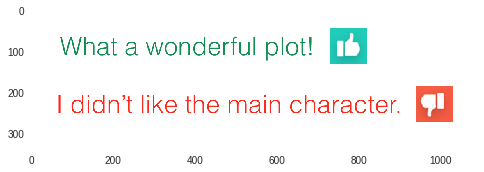

In [41]:
### Reviews example image
reviews_example = mpimg.imread("/content/drive/My Drive/Images/reviews_ex.png") 
plt.imshow(reviews_example)
plt.grid(False)

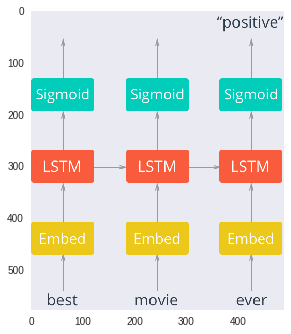

In [42]:
### Network architecture for this model
network_diagram = mpimg.imread("/content/drive/My Drive/Images/network_diagram.png") 
plt.imshow(network_diagram)
plt.grid(False)

In [0]:
### Read data from text files
with open("/content/drive/My Drive/Images/reviews.txt", 'r') as f:
    reviews = f.read()
with open("/content/drive/My Drive/Images/labels.txt", 'r') as f:
    labels = f.read()

In [44]:
print(reviews[:1000])
print()
print(labels[:20])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turn

**Data pre-processing.**

**The first step when building a neural network model is getting the data into the proper form to feed into the network.**

**Since I am using embedding layers, I will need to encode each word with an integer.**

**I will also want to clean it up a bit.**

**You can see an example of the reviews data above.**

**Here are the processing steps, I'll want to take:**            

*   **I want to get rid of periods and extraneous punctuation.**
*   **Also, you might notice that the reviews are delimited with newline characters `\n`. To           deal with those, I'm going to split the text into each review using `\n` as the delimiter.** 
*   **Then I can combine all the reviews back together into one big string.**     
              
**First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.**

In [0]:
### Get rid of punctuation
reviews = reviews.lower() # lowercase, standardize
all_text = ''.join([c for c in reviews if c not in punctuation])

### Split by new lines and spaces
reviews_split = all_text.split('\n')
all_text = ' '.join(reviews_split)

### Create a list of words
words = all_text.split()

In [46]:
words[:30]

['bromwell',
 'high',
 'is',
 'a',
 'cartoon',
 'comedy',
 'it',
 'ran',
 'at',
 'the',
 'same',
 'time',
 'as',
 'some',
 'other',
 'programs',
 'about',
 'school',
 'life',
 'such',
 'as',
 'teachers',
 'my',
 'years',
 'in',
 'the',
 'teaching',
 'profession',
 'lead',
 'me']

### Encoding the words

The embedding lookup requires that I pass in integers to the network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Then I can convert each of the reviews into integers so they can be passed into the network.

* **Now I will encode the words with integers.**
 
* **Build a dictionary that maps words to integers.**
 
* **Later I will pad the input vectors with zeros, to make sure the integers  start at 1, not 0**.
* **Also, convert the reviews to integers and store the reviews in a new list called `reviews_ints`. **

In [0]:
### Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

### Use the dict to tokenize each review in reviews_split
### Store the tokenized reviews in reviews_ints
reviews_ints = []
for review in reviews_split:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

**Test the code**

As a text that I have implemented the dictionary correctly, print out the number of unique words in the vocabulary and the contents of the first, tokenized review.

In [48]:
### Stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  # should ~ 74000+
print()

### Print tokens in first review
print('Tokenized review: \n', reviews_ints[:1])

Unique words:  74072

Tokenized review: 
 [[21025, 308, 6, 3, 1050, 207, 8, 2138, 32, 1, 171, 57, 15, 49, 81, 5785, 44, 382, 110, 140, 15, 5194, 60, 154, 9, 1, 4975, 5852, 475, 71, 5, 260, 12, 21025, 308, 13, 1978, 6, 74, 2395, 5, 613, 73, 6, 5194, 1, 24103, 5, 1983, 10166, 1, 5786, 1499, 36, 51, 66, 204, 145, 67, 1199, 5194, 19869, 1, 37442, 4, 1, 221, 883, 31, 2988, 71, 4, 1, 5787, 10, 686, 2, 67, 1499, 54, 10, 216, 1, 383, 9, 62, 3, 1406, 3686, 783, 5, 3483, 180, 1, 382, 10, 1212, 13583, 32, 308, 3, 349, 341, 2913, 10, 143, 127, 5, 7690, 30, 4, 129, 5194, 1406, 2326, 5, 21025, 308, 10, 528, 12, 109, 1448, 4, 60, 543, 102, 12, 21025, 308, 6, 227, 4146, 48, 3, 2211, 12, 8, 215, 23]]


**Encoding the labels.**

**The labels are "positive" or "negative".**

**To use these labels in the network, I need to convert them to 0 and 1.**

   * **Convert labels from `positive` and `negative` to 1 and 0, respectively, and place those in a new list, `encoded_labels`.**

In [0]:
### Convert labels: 1 = positive, 0 = negative 
labels_split = labels.split('\n')
encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels_split])

**Removing Outliers.**

**As an additional pre-processing step, I want to make sure that the reviews are in good shape for standard processing. That is, the network will expect a standard input text size, and so, I'll want to shape the reviews into a specific length. I will approach this task in two main steps:**

1. Getting rid of extremely long or short reviews; the outliers
2. Padding/truncating the remaining data so that we have reviews of the same length.

**Before I pad the review text, I will check for reviews of extremely short or long lengths; outliers that may mess with the model training.**

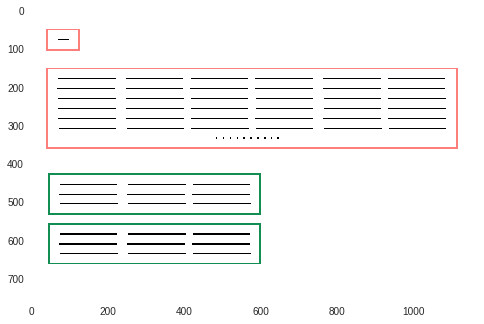

In [50]:
### Outlier image
outlier_image = mpimg.imread("/content/drive/My Drive/Images/outliers_padding_ex.png") 
plt.imshow(outlier_image)
plt.grid(False)

In [51]:
### Outlier review stats
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


 **I seem to have one review with zero length.**
 
 **And, the maximum review length is way too many steps for the RNN.**
 
 **I will remove any super short reviews and truncate super long reviews. This removes             outliers and should allow the model to train more efficiently.**

   * Remove *any* reviews with zero length from the `reviews_ints` list and their corresponding label in `encoded_labels`.

In [52]:
print('Number of reviews before removing outliers: ', len(reviews_ints))

### Remove any reviews/labels with zero length from the reviews_ints list.

### Get indices of any reviews with length 0
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

### Remove 0-length reviews and their labels
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(reviews_ints))

Number of reviews before removing outliers:  25001
Number of reviews after removing outliers:  25000


---
**Padding sequences.**

**To deal with both short and very long reviews, I will pad or truncate all the reviews to a specific length. For reviews shorter than some `seq_length`, I will pad with 0s. For reviews longer than `seq_length`, I can truncate them to the first `seq_length` words. A good `seq_length`, in this case, is 200.**

**I will define a function that returns an array `features` that contains the padded data, of a standard size, that I will pass to the network.** 

  * The data should come from `review_ints`, since I want to feed integers to the network. 
  * Each row should be `seq_length` elements long. 
  * For reviews shorter than `seq_length` words, **left pad** with 0s. That is, if the review is `['best', 'movie', 'ever']`, `[117, 18, 128]` as integers, the row will look like `[0, 0, 0, ..., 0, 117, 18, 128]`. 
  * For reviews longer than `seq_length`, use only the first `seq_length` words as the feature vector.

As a small example, if the `seq_length=10` and an input review is: 
```
[117, 18, 128]
```
The resultant, padded sequence should be: 

```
[0, 0, 0, 0, 0, 0, 0, 117, 18, 128]
```
**The final `features` array should be a 2D array, with as many rows as there are reviews, and as many columns as the specified `seq_length`.**






This isn't trivial and there are a bunch of ways to do this. But, if you're going to be building your own deep learning networks, you're going to have to get used to preparing your data.

In [0]:
### Define 'pad_features'
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    ### Getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    ### For each review, grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [54]:
### Test the implementation

seq_length = 200

features = pad_features(reviews_ints, seq_length=seq_length)

### Test statements 
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

### Print first 10 values of the first 30 batches 
print(features[:30,:10])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [22382    42 46418    15   706 17139  3389    47    77    35]
 [ 4505   505    15     3  3342   162  8312  1652     6  4819]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   54    10    14   116    60   798   552    71   364     5]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    1   330   578    34     3   162   748  2731     9   325]
 [    9    11 10171  5305  1946   689   444    22   280   673]
 [    0     0     0     0     0     0     0     0     0

**Training, Validation, Test.**

With my data in nice shape, I will split it into training, validation, and test sets.

            **Create the training, validation, and test sets.**    

* Create sets for the features and the labels, `x_train` and `y_train`.        
* Define a split fraction, `split_frac` as the fraction of data to **keep** in the training set.      Usually this is set to 0.8 or 0.9. 
* Whatever data is left will be split in half to create the validation and *testing* data.
 



 

In [55]:
### Split data into training, validation, and test data (features and labels, x and y)
split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

### Print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)


**Check my code.**

With train, validation, and test fractions equal to 0.8, 0.1, 0.1, respectively, the final, feature data shapes should look like:
```
                    Feature Shapes:
Train set: 		 (20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		  (2500, 200)
```

---
**DataLoaders and Batching.**

After creating training, test, and validation data, I can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets.

```
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, batch_size=batch_size)
```

This is an alternative to creating a generator function for batching the data into full batches.

In [0]:
### Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

### Dataloaders
batch_size = 50

### SHUFFLE the training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [57]:
### Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,     6,     1,  2155],
        [    0,     0,     0,  ...,    56,    67,  9209],
        [ 7935,  7364,    13,  ...,     5,    75,     9],
        ...,
        [  674,  5557,  2619,  ..., 16598,   769,   608],
        [    0,     0,     0,  ...,    79,    29,   736],
        [    0,     0,     0,  ...,    38,  1365,  8262]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0])


---
**Sentiment Network with PyTorch.**

**I will define the network.**


The layers are as follows:
1. An [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) that converts the word tokens (integers) into embeddings of a specific size.
2. An [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the LSTM layer outputs to a desired output_size
4. A sigmoid activation layer which turns all outputs into a value 0-1; return **only the last sigmoid output** as the output of this network.

### The Embedding Layer

**I need to add an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) because there are 74000+ words in the vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, I can have an embedding layer and use that layer as a lookup table. I could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.**


### The LSTM Layer(s)

I will create an [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) to use in the recurrent network, which takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.

Most of the time, the network will have better performance with more layers; between 2-3. Adding more layers allows the network to learn really complex relationships. 

   * ** Complete the `__init__`, `forward`, and `init_hidden` functions for the SentimentRNN model class.**

Note: `init_hidden` should initialize the hidden and cell state of an lstm layer to all zeros, and move those state to GPU, if available.

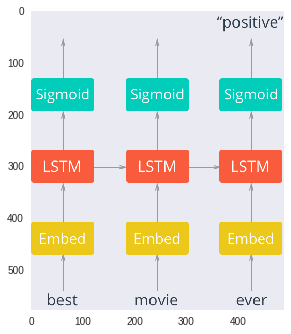

In [58]:
### Network diagram
network_diagram = mpimg.imread("/content/drive/My Drive/Images/network_diagram.png") 
plt.imshow(network_diagram)
plt.grid(False)

In [59]:
### Checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [0]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        ### Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ### Dropout layer
        self.dropout = nn.Dropout(0.3)
        
        ### Linear and Sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        ### Embeddings and LSTM outputs
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        ### Stack up LSTM outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        ### Dropout and Fully-Connected layers
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        ### Sigmoid function
        sig_out = self.sig(out)
        
        ### Reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        ### Return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        ### Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        ### Initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

## Instantiate the network

Here, I will instantiate the network. First up, defining the hyperparameters.

* `vocab_size`: Size of the vocabulary or the range of values for the input, word tokens.
* `output_size`: Size of the desired output; the number of class scores I want to output (pos/neg).
* `embedding_dim`: Number of columns in the embedding lookup table; size of the embeddings.
* `hidden_dim`: Number of units in the hidden layers of the LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `n_layers`: Number of LSTM layers in the network. Typically between 1-3

      
      * Define the model  hyperparameters.


In [61]:
### Define the hyperparameters
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

### Instantiate the model
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


---
## Training

Below is the training code.

>I will also be using a new kind of cross entropy loss, which is designed to work with a single Sigmoid output. [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss), or **Binary Cross Entropy Loss**, applies cross entropy loss to a single value between 0 and 1.

I also have some data and training hyparameters:

* `lr`: Learning rate for our optimizer.
* `epochs`: Number of times to iterate through the training dataset.
* `clip`: The maximum gradient value to clip at (to prevent exploding gradients).

In [0]:
### Loss function 
criterion = nn.BCELoss()

### Optimization function
lr=0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [63]:
### Training hyperparams

epochs = 1 

counter = 0
print_every = 100
clip=5 # gradient clipping

### Move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
### Train for some number of epochs
for e in range(epochs):
    
    ### Initialize hidden state
    h = net.init_hidden(batch_size)

    ### Batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        ### Creating new variables for the hidden state, otherwise
        ### The model would backprop through the entire training history
        h = tuple([each.data for each in h])

        ### Zero accumulated gradients
        net.zero_grad()

        ### Get the output from the model
        output, h = net(inputs, h)

        ### Calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        
        ### `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        ### Loss stats
        if counter % print_every == 0:
            ### Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                ### Creating new variables for the hidden state, otherwise
                ### The model would backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/1... Step: 100... Loss: 0.665864... Val Loss: 0.642021
Epoch: 1/1... Step: 200... Loss: 0.633004... Val Loss: 0.590997
Epoch: 1/1... Step: 300... Loss: 0.718273... Val Loss: 0.701301
Epoch: 1/1... Step: 400... Loss: 0.473317... Val Loss: 0.562655


---
## Testing

There are a few ways to test the network.

* **Test data performance:** First, I will see how the trained model performs on all of the defined test_data, above. I will calculate the average loss and accuracy over the test data.

* **Inference on user-generated data:** Second, I will see if I can input just one example review at a time (without a label), and see what the trained model predicts. Looking at new, user input data like this, and predicting an output label, is called **inference**.

In [64]:
### Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

### Init hidden state
h = net.init_hidden(batch_size)

net.eval()
### Iterate over test data
for inputs, labels in test_loader:

    ### Creating new variables for the hidden state, otherwise
    ### The model would backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    ### Get predicted outputs
    output, h = net(inputs, h)
    
    ### Calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    ### Convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    ### Compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


### Print stats
### Avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

### Accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.551
Test accuracy: 0.728


### Inference on a test review

  See if the model predicts correctly.
    
 Write a `predict` function that takes in a trained net, a plain text_review, and a sequence length, and prints out a custom statement for a positive or negative review.
  
  * The 'predict' function should just take in a trained net, a text review, and a sequence length.

In [0]:
### Negative test review
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'

In [66]:
def tokenize_review(test_review):
    test_review = test_review.lower() # lowercase
    ### Get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    ### Splitting by spaces
    test_words = test_text.split()

    ### Tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])

    return test_ints

### Test code and generate tokenized review
test_ints = tokenize_review(test_review_neg)
print(test_ints)

[[1, 247, 18, 10, 28, 108, 113, 14, 388, 2, 10, 181, 60, 273, 144, 11, 18, 68, 76, 113, 2, 1, 410, 14, 539]]


In [67]:
### Test sequence padding
seq_length=200
features = pad_features(test_ints, seq_length)

print(features)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   1 247  18  10  28
  108 113  14 388   2  10 181  60 273 144  11  18  68  76 113   2   1 410
   14 539]]


In [68]:
### Test conversion to tensor and pass into the model
feature_tensor = torch.from_numpy(features)
print(feature_tensor.size())

torch.Size([1, 200])


In [0]:
def predict(net, test_review, sequence_length=200):
    
    net.eval()
    
    ### Tokenize review
    test_ints = tokenize_review(test_review)
    
    ### Pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    ### Convert to tensor to pass into the model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    ### Initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    ### Get the output from the model
    output, h = net(feature_tensor, h)
    
    ### Convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    
    ### Printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    ### Print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")

In [0]:
### Positive test review
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'

In [71]:
### Call the 'predict' function
seq_length=200 # good to use the length that was trained on

predict(net, test_review_neg, seq_length)

Prediction value, pre-rounding: 0.239324
Negative review detected.


I have trained the model and made predictions.

you can pass in _any_ kind of text and this model will predict whether the text has a positive or negative sentiment. 